In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import numba
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
import pickle
import seaborn as sns
sns.set(
    style='ticks',
    font_scale=1.5
)
from rakott.mpl import fig_panel_labels
import string

# Modifier model

| pheno-genotype     | mA  | mB     | MA  | MB     |
|------|-----|--------|-----|--------|
| frequency    | $x_1$  | $x_2$ | $x_3$  | $x_4$ |
| fitness    | $\omega_A$ | $\omega_B$    | $\omega_A$ | $\omega_B$    |
| vertical transmission rate | $\rho$   | $\rho$      | $P$   | $P$      |


The population recurrence is 

$$
\bar{\omega} x_1' = x_1 \omega_A ((1-\rho)(x_1 + x_3)+\rho) + x_2 \omega_B(1-\rho)(x_1 + x_3) \\
\bar{\omega} x_2' = x_1 \omega_A (1-\rho)(x_2 + x_4) + x_2 \omega_B ((1-\rho)(x_2 + x_4) + \rho) \\
\bar{\omega} x_3' = x_3 \omega_A ((1-P)(x_1 + x_3) + P) + x_4 \omega_B (1-P)(x_1 + x_3) \\
\bar{\omega} x_4' = x_3 \omega_A (1-P)(x_2 + x_4) + x_4 \omega_B ((1-P)(x_2 + x_4) + P) \\
\bar{\omega} = \omega_A (x_1 + x_3) + \omega_B (x_2 + x_4)
$$

# Modifier numerical simulation

In [2]:
@numba.jit()
def recursion(x, wA, wB, ρ, P, N=0):
    x1, x2, x3, x4 = x
    x1_ = x1 * wA * ((1 - ρ) * (x1 + x3) + ρ) + x2 * wB * (1 - ρ) * (x1 + x3)
    x2_ = x1 * wA * (1 - ρ) * (x2 + x4) + x2 * wB * ((1 - ρ) * (x2 + x4) + ρ)
    x3_ = x3 * wA * ((1 - P) * (x1 + x3) + P) + x4 * wB * (1 - P) * (x1 + x3)
    x4_ = x3 * wA * (1 - P) * (x2 + x4) + x4 * wB * ((1 - P) * (x2 + x4) + P)
    x = x1_, x2_, x3_, x4_
    x = np.array(x)
    x /= x.sum()
    if N > 0:
        x = np.random.multinomial(N, x) / N
    return x

recursion((0.25,0.25,0.25,0.25), 1, 0.5, 0.1, 0.9, 0)

array([ 0.25833333,  0.24166667,  0.325     ,  0.175     ])

In [3]:
@numba.jit()
def evolution(W, w, ρ0=0.1, m0=0.999, A0=0.1, N=0, factor=0.1):
    n = len(W)
    assert len(w) == n
    N = int(N)
    ρ = ρ0
    P = ρ * factor
    W_, w_ = W[0], w[0]
    x = np.zeros((4, n))
    x[:, 0] = [m0*A0, m0*(1-A0), (1-m0)*A0, (1-m0)*(1-A0)]
    wbar = np.empty(n, dtype=float)
    rate = np.empty(n, dtype=float)    
    invasions = []

    for t in range(n-1):
        W_, w_ = W[t], w[t]
        rate[t] = ρ * (x[0,t] + x[1,t]) + P * (x[2,t] + x[3,t])
        wbar[t] = (x[0,t] + x[2,t]) * W_ + (x[1,t] + x[3,t]) * w_
        x[:, t+1] = recursion(
            x[:, t], W_, w_, ρ, P, N
        )
        t = t+1
        if x[0,t] + x[1,t] > 0.999:
            if x[0,t] > x[1,t]:
                x[0,t] -= 0.0001
                x[2,t] += 0.0001
            else:
                x[1,t] -= 0.0001
                x[3,t] += 0.0001        
        if x[0,t] + x[1,t] < 0.0001 and 0 < ρ < 1:
            x[0,t], x[1,t], x[2,t], x[3,t] = x[2,t], x[3,t], x[0,t], x[1,t]
            print(t, P, end=', ')
            invasions.append((t, P))
            ρ, P = P, min(max(P * factor, 0.0), 1.0)
    wbar[-1] = wbar[-2]
    return x, invasions, wbar

In [4]:
def plot_invasions(x, invasions, wbar, ρ0, time_step=1, inset=None, factor=0.1, 
                   panel_labels=string.ascii_uppercase, filename=None):
    if wbar is not None:
        rows = 3
    else:
        rows = 2

    fig, axes = plt.subplots(rows, 1, figsize=(6, 4*rows), sharey=False, sharex=True)
    axes[0].plot(
        np.arange(0, x.shape[1], time_step),
        x[0,::time_step] + x[2,::time_step], 
        label='A'
    )
#     axes[0].axhline(0.5, ls='--', color='k', alpha=0.8)
    t = 0
    for i, (inv, rate) in enumerate(invasions):
        for j in range(rows): axes[j].axvline(inv, ls='--', lw=1, color='gray')        
        axes[1].plot(
            np.arange(t, inv, time_step),
            x[2,t:inv:time_step] + x[3,t:inv:time_step], 
            label='{:g}'.format(rate)
        )
        t = inv
    
    if wbar is not None:
        axes[2].plot(
            np.arange(0, wbar.shape[0], time_step),
            wbar[::time_step]
        )

        # inset ################
        if inset is not None:
            axins = inset_axes(axes[2], width="50%", height="40%", loc=4)
            axins.plot(
                np.arange(inset, wbar.shape[0], time_step),
                wbar[inset::time_step]
            )
            axins.set(xscale='log', xlim=(inset, None), yscale='log', xticks=[], yticks=[])
            plt.xticks(visible=False)
            plt.yticks(visible=False)

            for i, (inv, rate) in enumerate(invasions):
                axins.axvline(inv, ls='--', lw=1, color='gray')

            mark_inset(axes[2], axins, loc1=2, loc2=1)
        ########################
    
    axes[0].set(ylim=(0,1), ylabel='Frequency of phenotype $A$')
    axes[1].set(ylim=(0,1), ylabel='Invader frequency')
    axes[1].legend(title='Rate')
    if wbar is not None:
        axes[2].set(ylabel=r'Mean fitness - $\bar{\omega}$', xlabel='Generations', xscale='log')
    else:
        axes[1].set(xlabel='Generations', xscale='log')

    labels = fig_panel_labels(axes, panel_labels, xcoord=-0.16, ycoord=1.025)
    fig.tight_layout()
    if filename is not None:
        fig.savefig(filename, bbox_inches='tight', bbox_extra_artists=labels)
    return fig, axes

In [ ]:
n = 1000000
for w in [0.1, 0.5, 0.9]:
    Ws = np.array([1, w]*(n//2))
    ws = np.array([w, 1]*(n//2))
    x, invasions, wbar = evolution(ρ0=0.1, n=n, W=Ws, w=ws, N=0)
    np.savez_compressed('A1B1_modifier_invasions_w{:.1f}.npz'.format(w), x=x, invasions=invasions, wbar=wbar)

In [ ]:
w = 0.1

d = np.load('A1B1_modifier_invasions_w{:.1f}.npz'.format(w))
x = d['x']
invasions = d['invasions']
wbar = d['wbar']
del d

In [ ]:
fig, axes = plot_invasions(x, invasions, wbar, ρ0=0.1, inset=10000, panel_labels='ABC',
        filename='../figures/A1B1_modifier_invasions_w{:.1f}.pdf'.format(w))

After creating several multi-panel figures, they can be merged with:
```sh
!pdfjam A1B1_modifier_invasions_w0.1.pdf  A1B1_modifier_invasions_w0.5.pdf A1B1_modifier_invasions_w0.9.pdf -o A1B1_modifier_invasions.pdf --landscape --nup 3x1
```

# AkBl

In [ ]:
def ab(ρ, W, w):
    return (1 + ρ * (W-w) / w) * (1 + ρ * (w-W)/W)

In [ ]:
ab(0.1, 1, 0.1)

In [ ]:
n = 60000
ρ0 = 0.9
factor = 1.03
w = 0.1
k = 40
l = 40
Ws = np.array(([1]*k + [w]*l)*(n//(k+l)))
ws = np.array(([w]*k + [1]*l)*(n//(k+l)))
x, invasions, wbar = evolution(Ws, ws, ρ0=ρ0, A0=0.5, N=0, factor=factor)
np.savez_compressed('A{}B{}_modifier_invasions_w{:.1f}.npz'.format(k, l, w), 
                    x=x, invasions=invasions, wbar=wbar)
invasions

In [ ]:
arit_wbar = np.mean(
    wbar.reshape(-1, (k+l)), 
    axis=1
)
geom_wbar = np.power(
    np.prod(
        wbar.reshape(-1, (k+l)), 
        axis=1
    ), (1/(k+l))
)

In [ ]:
fig, axes = plot_invasions(x, invasions, wbar, ρ0=ρ0, inset=None, factor=factor, panel_labels='ABC',)
#         filename='../figures/A{}B{}_modifier_invasions_w{:.1f}.pdf'.format(k, l, w))
axes[0].set_xscale('log')
# axes[2].plot(np.arange(0, n, k+l), arit_wbar, ls='--')
axes[2].plot(np.arange(0, n, k+l), geom_wbar, ls='-', alpha=0.5)
# axes[2].plot(np.arange(0, n, k+l), arit_wbar, ls='--', alpha=0.5)
fig.savefig('../figures/A{}B{}_modifier_invasions_w{:.1f}_ρ0{:.2f}.png'.format(k, l, w, ρ0))

## Stochastic environment

In [ ]:
n = 10000000
w = 0.1
rand = np.random.randint(0, 2, size=n, dtype=bool)
Ws = np.ones(n, dtype=float)
ws = np.ones(n, dtype=float)
Ws[rand] = w
ws[~rand] = w

In [ ]:
x, invasions, wbar = evolution(ρ0=0.1, W=Ws, w=ws, N=0)

In [ ]:
np.savez_compressed('stoch_modifier_invasions.npz', x=x, invasions=invasions, wbar=wbar)

In [ ]:
d = np.load('stoch_modifier_invasions.npz')
x = d['x']
invasions = d['invasions']
wbar = d['wbar']
del d

In [ ]:
fig, axes = plot_invasions(x, invasions, None, ρ0=0.1, 
                           time_step=100, inset=None, 
                           filename='../figures/stoch_modifier_invasions.png')
fig.savefig('../figures/stoch_modifier_invasions.png')

# Evolutionary stable rate

In [154]:
@numba.jit()
def invasion(x1, wA, wB, ρ, P, inv_rate=1e-4):
    n = len(wA)
    assert len(wA) == len(wB)
    x = np.array(
        [x1*(1-inv_rate), (1-x1)*(1-inv_rate), x1*inv_rate, (1-x1)*inv_rate]
    )
    assert np.isclose(x.sum(), 1)
    
    for t in range(n):
        wA_ = wA[t]
        wB_ = wB[t]
        x = recursion(x, wA_, wB_, ρ, P, N=0)
    if (x[2] + x[3]) > inv_rate:
        return P
    else:
        return ρ

@numba.jit()
def stable_x(wA, wB, ρ, x0=0.5):
    n = len(wA)
    x = np.array([x0, 1-x0, 0, 0])
    for t in range(n):
        wA_ = wA[t]
        wB_ = wB[t]
        x = recursion(x, wA_, wB_, ρ, 0, N=0)
    return x

In [6]:
# @numba.jit()
def is_polymorphism(w, ρ, k, l):
    # see eq 22
    s = 1 - w
    if ρ*s == 0:
        return True
    elif k == l:
        return True
    elif l > k:
        return l/k < -np.log(1+ρ*s/(1-s))/np.log(1-ρ*s) 
    else: # k > l
        return k/l < -np.log(1+ρ*s/(1-s))/np.log(1-ρ*s) 

In [111]:
def max_ρ_with_polymorphism(w, k, l, num_pts=1001):
    for ρ_ in np.linspace(0, 1, num_pts)[::-1]:
        if is_polymorphism(w, ρ_, k, l): 
            return ρ_

In [7]:
# @numba.jit()
def draw_ρ(w, k, l, ρ=None):
    if ρ is None:
        for _ in range(100):
            ρ = np.random.rand()
            if is_polymorphism(w, ρ, k, l):
                return ρ
        return 0
    else:
        for _ in range(100):
            P = ρ * min(max(ρ * np.random.exponential(1), 0), 1)
            if is_polymorphism(w, P, k, l):
                return P
        return ρ

In [9]:
# @numba.jit()
def evol_stable(w, k, l=None, reps=1, PRINT=False):
    if l is None:
        l = k
    wA = np.array(([1] * k + [w] * l)*5000)
    wB = np.array(([w] * k + [1] * l)*5000)

    results = np.empty(reps)
    for i in range(reps):
        ρ = draw_ρ(w, k, l)
        x = stable_x(wA, wB, ρ)
        if PRINT:
            print('ρ0:', ρ)

        failed_invasions = 0
        invasions = 0
        while True:
            P = draw_ρ(w, k, l, ρ=ρ)
            P = invasion(x[0], wA, wB, ρ, P)
            invasions += 1
            if P == ρ:
                failed_invasions += 1
            else:
                failed_invasions = 0
                ρ = P
                x = stable_x(wA, wB, ρ)
                if PRINT:
                    print('ρ: {:.3f} ({})'.format(ρ, invasions), end=', ')

            if failed_invasions >= 100 and invasions >= 500:
                break            
        # if ρ is almost 0 or almost 1, try to invade with 0 or 1.
        if ρ < 1e-3:
            x = stable_x(wA, wB, ρ)
            ρ = invasion(x[0], wA, wB, ρ, 0.0)
        elif ρ > 1 - 1e-3:
            x = stable_x(wA, wB, ρ)
            ρ = invasion(x[0], wA, wB, ρ, 1.0)
        if PRINT:
            print()
            print('ρ: {:.3f} ({})'.format(ρ, invasions))
        results[i] = ρ
    return results

In [10]:
ks = np.arange(1, 51, 1)

In [ ]:
for w in [0.1, 0.5, 0.9]:
    def task(k):
        return evol_stable(w=w, k=k, l=k, reps=10, PRINT=False)

    with ProcessPoolExecutor() as exe:
        ρs = exe.map(task, ks)
    ρs = np.array(list(ρs))
    df = pd.DataFrame(ρs)
    df['k'] = ks
    df = pd.melt(df, id_vars='k', var_name='rep', value_name='ρ')
    df.to_csv('evol_stable_w{:.1f}.csv'.format(w))

### Figure from data

In [14]:
df01 = pd.read_csv('evol_stable_w{:.1f}.csv'.format(0.1))
df05 = pd.read_csv('evol_stable_w{:.1f}.csv'.format(0.5))
df09 = pd.read_csv('evol_stable_w{:.1f}.csv'.format(0.9))
df01['w'] = 'w=0.1'
df01['color'] = mpl.colors.rgb2hex(sns.color_palette()[0])
df05['w'] = 'w=0.5'
df05['color'] = mpl.colors.rgb2hex(sns.color_palette()[1])
df09['w'] = 'w=0.9'
df09['color'] = mpl.colors.rgb2hex(sns.color_palette()[2])
df01.drop(['Unnamed: 0'], axis=1, inplace=True)
df05.drop(['Unnamed: 0'], axis=1, inplace=True)
df09.drop(['Unnamed: 0'], axis=1, inplace=True)
df = pd.concat((df01, df05, df09), axis=0)

In [15]:
meanρ = df.groupby(['k', 'w', 'color'])['ρ'].agg(np.mean).reset_index()
stdρ = df.groupby(['k', 'w', 'color'])['ρ'].agg(np.std).reset_index()

/Users/yoavram/miniconda3/envs/Milpitas/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in true_divide


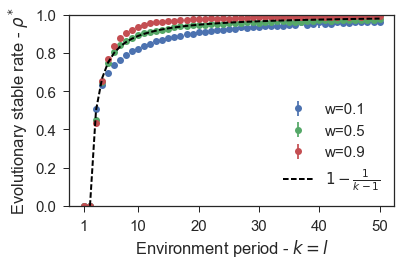

In [16]:
fig, ax = plt.subplots()

for w_ in df['w'].unique():
    _df = meanρ[meanρ['w']==w_]
    _std = stdρ[stdρ['w']==w_]
    c = _df['color'].unique()[0]
    ax.errorbar(_df['k'], _df['ρ'], _std['ρ'], fmt='o', color=c, label=w_)
ax.errorbar(np.sort(ks), 1-1/np.sort(ks-1), lw=2, color='k', ls='--', label=r'$1-\frac{1}{k-1}$')

ax.set(
    xticks=[1, 10, 20, 30, 40, 50],
    xticklabels=[1, 10, 20, 30, 40, 50],
    xlabel=r'Environment period - $k=l$',
    ylim=(0, 1),
    ylabel=r'Evolutionary stable rate - $\rho^*$',
)
ax.legend()
ax.figure.tight_layout()
# ax.figure.savefig('../figures/rho_evol_stability.pdf')

## Reduction

In [183]:
@numba.jit()
def reduction(w, k, l=None, factor=0.99, cycles=1000, ρ0=-1.0, PRINT=False):
    if l is None:
        l = k
    wA = np.array(([1] * k + [w] * l) * cycles)
    wB = np.array(([w] * k + [1] * l) * cycles)

    assert factor > 0, factor
    if ρ0 < 0:
        ρ = max_ρ_with_polymorphism(w, k, l, num_pts=1001)
    else:
        ρ = ρ0
    x = stable_x(wA, wB, ρ)
    if PRINT:
        print('ρ0:', ρ)
    invasions = 0
    while True:
        invasions += 1
        P = ρ * factor
        if P > 1 or P < 0:
            break
        P = invasion(x[0], wA, wB, ρ, P)
        if P != ρ:
            ρ = P
            x = stable_x(wA, wB, ρ)
            if PRINT:
                print('ρ: {:.3f} ({})'.format(ρ, invasions), end=', ')
        else:
            break            
    if PRINT:
        print()
        print('ρ: {:.3f} ({})'.format(ρ, invasions))        
    return ρ

In [142]:
reduction(0.1, 2, 2)

(7.663868923667706e-06, 1173)

In [143]:
reduction(0.5, 2, 2)

(2.8052238853412336e-06, 1273)

In [144]:
reduction(0.9, 2, 2)

(3.0096858462129677e-06, 1266)

In [195]:
reduction(0.1, 20, 20, factor=0.99, cycles=10000)

0.9043820750088043

In [197]:
reduction(0.1, 20, 20, factor=1.01, ρ0=1e-4, cycles=10000)

0.9086118256718908

## Table

In [156]:
rows = [
    dict(w=0.1, k=3, l=10),
    dict(w=0.1, k=5, l=30),
    dict(w=0.5, k=3, l=10),
    dict(w=0.5, k=5, l=30),
    dict(w=0.9, k=3, l=10),
    dict(w=0.9, k=5, l=30),
    dict(w=0.1, k=12, l=12),
    dict(w=0.5, k=12, l=12),
    dict(w=0.9, k=12, l=12),
    dict(w=0.1, k=30, l=30), 
    dict(w=0.5, k=30, l=30), 
    dict(w=0.9, k=30, l=30), 
    dict(w=0.1, k=1, l=1), 
    dict(w=0.1, k=1, l=2), 
    dict(w=0.1, k=2, l=2), 
    dict(w=0.5, k=1, l=1), 
    dict(w=0.5, k=1, l=2), 
    dict(w=0.5, k=2, l=2), 
    dict(w=0.9, k=1, l=1), 
    dict(w=0.9, k=1, l=2), 
    dict(w=0.9, k=2, l=2), 
]
for row in rows:
    row['ρ*'] = reduction(reps=5, **row)

In [157]:
df = pd.DataFrame(rows)
df.sort_values(['k','l','w'], inplace=True)
df.to_csv('reduction_ρ.csv', index=False)
df

,k,l,w,ρ*
12,1,1,0.1,1.746358e-14
15,1,1,0.5,1.167029e-13
18,1,1,0.9,5.159567e-12
13,1,2,0.1,1.824747e-14
16,1,2,0.5,0.000000e+00
19,1,2,0.9,0.000000e+00
14,2,2,0.1,7.655763e-05
17,2,2,0.5,2.830563e-05
20,2,2,0.9,2.508968e-05
0,3,10,0.1,4.130000e-01


# Modifier polymorphism?

In [ ]:
w = 0.5
k = l = 3
evol_stable(w, k, l)

In [ ]:
n = 10000000
wA = np.array(([1] * k + [w] * l) * n)
wB = np.array(([w] * k + [1] * l) * n)

ρ, P = 0.447, 0.448

x = np.empty((len(wA), 4))
x[0, :] = 0.25

for t in range(len(wA)-1):
    wA_ = wA[t]
    wB_ = wB[t]
    x[t+1,:] = recursion(x[t,:], wA_, wB_, ρ, P, N=0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(x[::(k+l), :2], ls='-', lw=3)
ax.plot(x[::(k+l), 2:], ls='--', lw=2)
ax.legend(['mA','mB','MA', 'MB'], frameon=True)
ax.set(
    xlabel='Periods',
    ylabel='Frequency',
    ylim=(0, 1)
);